In [3]:
import os
import pandas as pd
import numpy as np
import math
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from itertools import combinations
from scipy.stats import t as tstudent
from scipy.stats import f as ffisher
import scipy
from scipy import stats
import statistics
import statsmodels.api as sm
from sklearn.metrics import *

In [281]:
import cianparser
import io
import sys
import ast
import kaleido
import plotly.io as pio
import pingouin as pg

In [163]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
# !pip install kaleido >> None
!pip install pingouin >> None

# Предобработка данных

In [ ]:
### Определим значение наших столбцов
#  `date` - дата публикации объявления; 
#  `time` - время публикаци объявления; 
#  `geo_lat` - значение координаты (широта);
#  `geo_lo` - значение координаты (долгота);
#  `region` - код региона РФ;
#  `building_type` - Тип здания. 0 - Прочее. 1 - Панельный дом. 2 - Монолит. 3 - Кирпичный. 4 - Блочный. 5 - Деревянный; 
#  `object_type` - Тип квартиры. 1 - Вторичное жилье; 11 - Новая квартира в новостройке;
#  `level` - Этаж, на котором находится квартира; 
#  `levels` - Количество этажей;
#  `rooms` - Количество жилых комнат. Если значение -1 - это значит, что квартира является "студией";
#  `area` - Совокупная площадь квартиры;
#  `kitchen_area` - Площадь кухни; 
#  `price` - Цена в рублях РФ.

In [298]:
df = pd.read_csv('./all_v2.csv')

In [299]:
# смотрим есть ли пропущенные значения
Missing_Value = df.isnull().sum().sort_values(ascending = False)
Missing_Percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
Missing_Data = pd.concat([Missing_Value, Missing_Percent], axis=1, keys=['Пропущенные значения', 'Процент'])
Missing_Data.reset_index()

,index,Пропущенные значения,Процент
0,price,0,0.0
1,date,0,0.0
2,time,0,0.0
3,geo_lat,0,0.0
4,geo_lon,0,0.0
5,region,0,0.0
6,building_type,0,0.0
7,level,0,0.0
8,levels,0,0.0
9,rooms,0,0.0


In [300]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5477006 entries, 0 to 5477005
Data columns (total 13 columns):
 #   Column         Dtype  
---  ------         -----  
 0   price          int64  
 1   date           object 
 2   time           object 
 3   geo_lat        float64
 4   geo_lon        float64
 5   region         int64  
 6   building_type  int64  
 7   level          int64  
 8   levels         int64  
 9   rooms          int64  
 10  area           float64
 11  kitchen_area   float64
 12  object_type    int64  
dtypes: float64(4), int64(7), object(2)
memory usage: 543.2+ MB


In [249]:
# посмотрим на box_plotы всех полей данных

In [302]:
# Удалим нижний и верхний выбросы в столбце "area"
q_low = df['area'].quantile(0.01)     
q_hi  = df['area'].quantile(0.99)
df = df[(df['area'] < q_hi) & (df['area'] > q_low)]

# Удалим нижний и верхний выбросы в столбце "price"
q_low = df["price"].quantile(0.01)       
q_hi  = df["price"].quantile(0.99)
df = df[(df["price"] < q_hi) & (df["price"] > q_low)]

# Удалим нижний и верхний выбросы в столбце "price"
q_low = df["kitchen_area"].quantile(0.01)       # Удалим нижний и верхний выбросы в столбце "Площадь кухни", объединив условие с оператором AND:
q_hi  = df["kitchen_area"].quantile(0.99)
df = df[(df["kitchen_area"] < q_hi) & (df["kitchen_area"] > q_low)]

In [304]:
df.describe()

,price,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
count,5.133155e+06,5.133155e+06,5.133155e+06,5.133155e+06,5.133155e+06,5.133155e+06,5.133155e+06,5.133155e+06,5.133155e+06,5.133155e+06,5.133155e+06
mean,3.883889e+06,5.399444e+01,5.331936e+01,4.326687e+03,1.936925e+00,6.239239e+00,1.144320e+01,1.726576e+00,5.238541e+01,1.032502e+01,3.965827e+00
std,2.907255e+06,4.624061e+00,2.074043e+01,3.296426e+03,1.036137e+00,4.932139e+00,6.490420e+00,1.016158e+00,1.862127e+01,4.180956e+00,4.567510e+00
min,7.707770e+05,4.145906e+01,1.989020e+01,3.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,-2.000000e+00,1.986000e+01,3.020000e+00,1.000000e+00
25%,1.982000e+06,5.335449e+01,3.782957e+01,2.661000e+03,1.000000e+00,3.000000e+00,5.000000e+00,1.000000e+00,3.880000e+01,7.000000e+00,1.000000e+00
50%,2.980000e+06,5.515123e+01,4.357486e+01,2.922000e+03,2.000000e+00,5.000000e+00,1.000000e+01,2.000000e+00,4.802000e+01,9.790000e+00,1.000000e+00
75%,4.700000e+06,5.618621e+01,6.565657e+01,6.171000e+03,3.000000e+00,9.000000e+00,1.600000e+01,2.000000e+00,6.250000e+01,1.230000e+01,1.100000e+01
max,2.003600e+07,7.198040e+01,1.625361e+02,6.188800e+04,5.000000e+00,3.900000e+01,3.900000e+01,9.000000e+00,1.381000e+02,2.819000e+01,1.100000e+01


In [305]:
region_name = {2661: 'Санкт-Петербург',
 3446: 'Ленинградская область',
 3: 'Москва',
 81: 'Московская область',
 2843: 'Краснодарский край',
 2871: 'Нижегородская область',
 3230: 'Ростовская область',
 3106: 'Самарская область',
 2922: 'Республика Татарстан',
 2900: 'Ставропольский край',
 2722: 'Республика Башкортостан',
 6171: 'Свердловская область',
 4417: 'Республика Коми',
 5282: 'Челябинская область',
 5368: 'Иркутская область',
 5520: 'Пермский край',
 6817: 'Алтайский край',
 9579: 'Республика Бурятия',
 2604: 'Ярославская область',
 1010: 'Удмуртская Республика',
 7793: 'Псковская область',
 13919: 'Республика Северная Осетия — Алания',
 2860: 'Кемеровская область',
 3019: 'Чувашская Республика',
 4982: 'Республика Марий Эл',
 9648: 'Кабардино-Балкарская Республика',
 5241: 'Республика Мордовия',
 3870: 'Красноярский край',
 3991: 'Тюменская область',
 2359: 'Республика Хакасия',
 9654: 'Новосибирская область',
 2072: 'Воронежская область',
 8090: 'Республика Карелия',
 4007: 'Республика Дагестан',
 11171: 'Республика Саха (Якутия)',
 10160: 'Забайкальский край',
 7873: 'Республика Крым',
 6937: 'Республика Крым',
 2594: 'Кировская область',
 8509: 'Республика Калмыкия',
 11416: 'Республика Адыгея',
 11991: 'Карачаево-Черкесская Республика',
 5178: 'Республика Тыва',
 13913: 'Республика Ингушетия',
 6309: 'Республика Алтай',
 5952: 'Белгородская область',
 6543: 'Архангельская область',
 2880: 'Тверская область',
 5993: 'Пензенская область',
 2484: 'Ханты-Мансийский автономный округ',
 4240: 'Липецкая область',
 5789: 'Владимирская область',
 14880: 'Ямало-Ненецкий автономный округ',
 1491: 'Рязанская область',
 2885: 'Чеченская Республика',
 5794: 'Смоленская область',
 2528: 'Саратовская область',
 4374: 'Вологодская область',
 4695: 'Волгоградская область',
 2328: 'Калужская область',
 5143: 'Тульская область',
 2806: 'Тамбовская область',
 14368: 'Мурманская область',
 5736: 'Новгородская область',
 7121: 'Курская область',
 4086: 'Хабаровский край',
 821: 'Брянская область',
 10582: 'Астраханская область',
 7896: 'Калининградская область',
 8640: 'Омская область',
 5703: 'Курганская область',
 10201: 'Томская область',
 4249: 'Ульяновская область',
 3153: 'Оренбургская область',
 4189: 'Костромская область',
 2814: 'Орловская область',
 13098: 'Камчатский край',
 8894: 'Ивановская область',
 7929: 'Амурская область',
 16705: 'Магаданская область',
 69: 'Еврейская автономная область',
 4963: 'Приморский край',
 1901: 'Сахалинская область',
 61888: 'Ненецкий автономный округ'}

In [306]:
df['region_name'] = df['region'].map(region_name) 
df['date'] = df['date'].map(lambda x: x[:7])

# мы хотим использовать date как регрессор, но это категориальная переменная, воспользуемся методом one hot encoding
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['date_encoded'] = label_encoder.fit_transform(df['date'])
encoding_dict = dict(zip(df['date'], df['date_encoded'])) # словарь соответствий

In [307]:
good_cols = ['price', 'date', 'date_encoded', 'building_type', 'level', 'levels', 'rooms', 'area', 'kitchen_area', 'object_type', 'region_name']

In [308]:
df = df[good_cols]

In [309]:
city_counts = df.groupby('region_name').size()

# Выбираем регионы, где суммарное количество наблюдений больше или равно 500
selected_regions = city_counts[city_counts >= 500].index
df = df[df['region_name'].isin(selected_regions)]

In [310]:
len(df['region_name'].unique())

76

# Графики hist и box plot по данным

In [311]:

def get_box_plot(df, region_name, save_path=None):
    df_region = df[df['region_name'] == region_name]
    # Box Plot
    plt.figure(figsize=(8, 6))
    plt.boxplot(df_region['price'], vert=False)
    plt.title(f'Box Plot {region_name}')
    plt.xlabel('Price')
    plt.savefig(save_path)
    plt.close()


def get_histogram(df, region_name, save_path=None):
    df_region = df[df['region_name'] == region_name] 

    # Histogram
    plt.figure(figsize=(8, 6))
    plt.hist(df_region['price'], bins=20, color='blue', alpha=0.7)
    plt.title(f'Histogram of price in {region_name}')
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    plt.savefig(save_path)
    plt.close()


# Пример использования с сохранением
for region_name in df['region_name'].unique():
    get_box_plot(df, region_name, save_path=f'./charts/boxplot/{region_name}.png')
    get_histogram(df, region_name, save_path=f'./charts/hist/{region_name}.png')


In [312]:
# матрица коэф корреляции 
def get_corr_matrx(df, region_name, path):
    df = df[df['region_name'] == region_name]
    number_features = df.select_dtypes(include=['float', 'int']).columns
    corr_df = df[number_features].corr()
    corr_df.style.background_gradient(cmap='coolwarm').set_caption(f'Матрица корреляции для {region_name}')
    sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Матрица корреляции {region_name}')
    plt.savefig(path)
    plt.close()

# матрица частных коэф корреляции 
def get_pcorr_matrix(df, region_name, path):
    df = df[df['region_name'] == region_name]
    number_features = df.select_dtypes(include=['float', 'int']).columns
    pcorr_df = df[number_features].pcorr().round(4)
    pcorr_df.style.background_gradient(cmap='coolwarm').set_caption(f'Матрица частных коэф-ов корреляции для {region_name}')
    sns.heatmap(pcorr_df, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Матрица частных коэффициентов корреляции {region_name}')
    plt.savefig(path)
    plt.close()


for region_name in df['region_name'].unique():
    get_corr_matrx(df, region_name, path=f'./charts/corr/{region_name}.png')
    get_pcorr_matrix(df, region_name, path=f'./charts/pcorr/{region_name}.png')

# Автоматизированный stepwise отбор факторных переменных

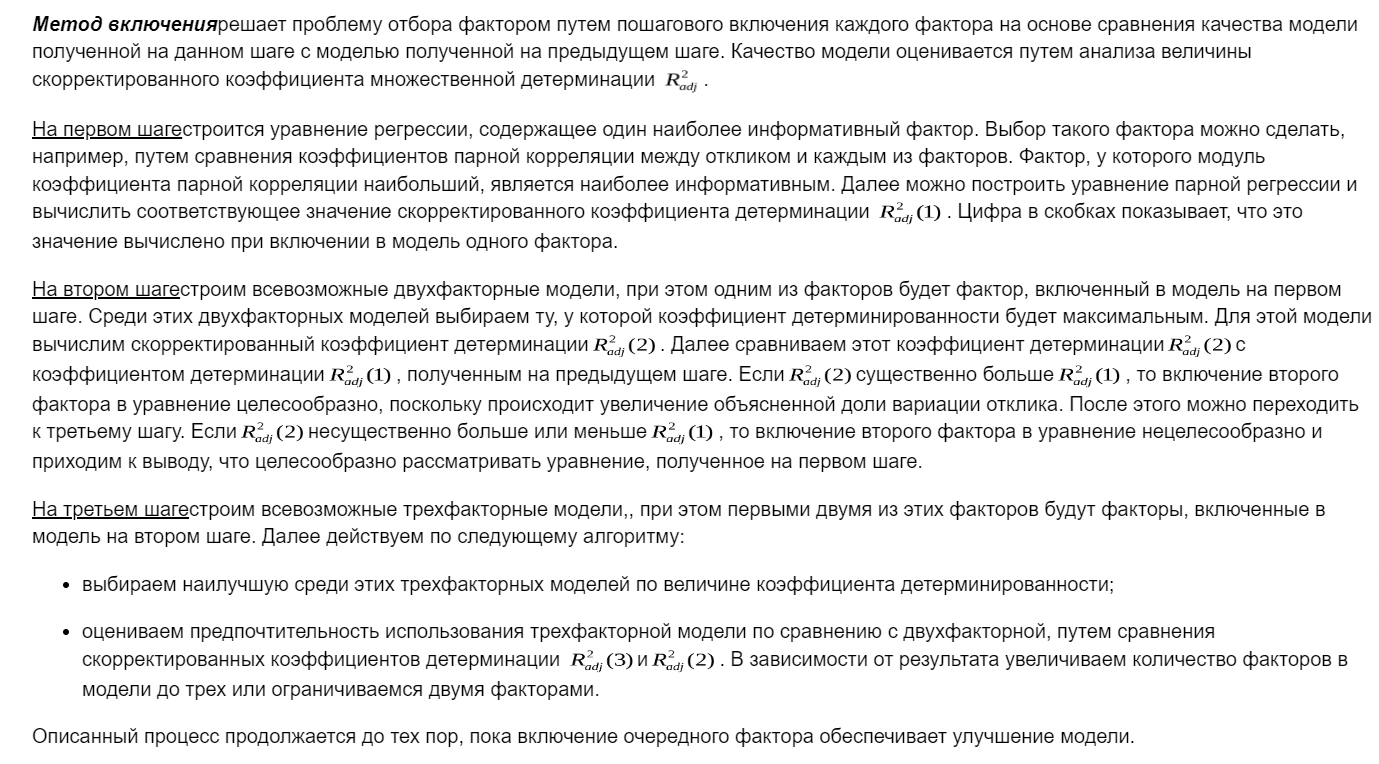

In [313]:
# Функция для пошагового отбора значимых факторов
# https://studfile.net/preview/2829140/page:8/

# 1) строится модель парной регрессии с фактором, коэф корреляции у которого с целевой переменной максимальный
# 2) Далее на каждом шаге цикла выбирается тот фактор, добавление которого в модель увеличивает R2 наибольшим образом
# при этом если рассматриваемый регрессор имеет сильную корреляционную связь с другими, уже отобранными факторными переменными
# такой фактор в модель не включается. отбор продолжается
# 3) в случае малого количества факторных переменных граница level (разница R2 старого и новых) уменьшается и отбор продолжается

def get_factors(df, xes):
    R2_max = -10**10
    # составляем словарь, где ключи - регрессоры, значение - коэф парной корр с переменной y
    corr_dict = {i:np.abs(df[i].corr(df['price'])) for i in xes}
    add_to_model = [] 
    # сортируем словарь по значениям коэф-ов корреляции
    sorted_corr_dict = dict(sorted(corr_dict.items(), key=lambda item: item[1], reverse = True))
    # добавляем самый значимый в модель
    name_best_factor = list(sorted_corr_dict.keys())[0]
    add_to_model.append(list(sorted_corr_dict.keys())[0])
    sorted_corr_dict.pop(name_best_factor)
    # строим парную регрессию и считаем R2
    y = df['price'].values
    X = sm.add_constant(np.column_stack([df[i] for i in add_to_model]))
    model = sm.OLS(y, X)
    results = model.fit()
    if R2_max < results.rsquared:
        R2_max = results.rsquared
    
    level = 0.0005 # минимальная разница между R2_max и новым R2 для добавления нового фактора в модель
    count = 0
    while True:
        r_dict = {}
        # перебираем все факторы, добавляя в модель и высчитывая r2
        for factor in sorted_corr_dict.keys():
            X = sm.add_constant(np.column_stack([df[i] for i in add_to_model+[factor]]))
            model = sm.OLS(y, X)
            results = model.fit()
            r_dict[factor] = results.rsquared
        
        # сортируем по значениям R2
        r_dict = dict(sorted(r_dict.items(), key=lambda item: item[1], reverse = True))
        best_factor = list(r_dict.keys())[0]
        if max(r_dict.values()) - R2_max > level: # R2 возрастает на значимую величину
            count1 = 0
            while True:
                # нет сильной зависимости между факторами, отбираемыми для модели
                corr_factors = {i:np.abs(df[i].corr(df[best_factor])) for i in add_to_model}
                if all([i<0.8 for i in corr_factors.values()]): # все хорошо
                    add_to_model.append(best_factor)
                    sorted_corr_dict.pop(best_factor)
                    R2_max = max(r_dict.values())
                    break
                # если сильная зависимость между фактором и уже отобранными регрессорами есть
                # то переходим к рассмотрению следующего по величине R2 фактора 
                else:
                    count1+=1
                    if count1 >= len(r_dict):
                        break
                    best_factor = list(r_dict.keys())[count1]
                            
        # выполняем процедуру до тех пор, пока в моделе не будет хотя бы 2 значимых факторов
        count += 1
        if count > 5 and len(add_to_model) < 3:
            level -= 0.0001
        if len(add_to_model) < 3 and level == 0.0005: 
            continue
        if level <= 0.0001:
            break
        if count > 100 and level > 0.0001:
            break
        if len(sorted_corr_dict) == 0:
            break
    return add_to_model
        

# get_factors(df)

In [314]:
df.head(3)

,price,date,date_encoded,building_type,level,levels,rooms,area,kitchen_area,object_type,region_name
0,6050000,2018-02,0,1,8,10,3,82.6,10.8,1,Санкт-Петербург
1,8650000,2018-02,0,3,5,24,2,69.1,12.0,1,Московская область
2,4000000,2018-02,0,1,5,9,3,66.0,10.0,1,Нижегородская область


In [ ]:
df_factors = pd.DataFrame(columns = ['region_name', 'factors'])
number_features = df.select_dtypes(include=['float', 'int']).columns

for region_name in df['region_name'].unique():
    print()
    df_temp = df[df['region_name'] == region_name]
    df_temp = df_temp[number_features]
    xes = df_temp.columns.tolist()
    xes.remove('price')
    factors = get_factors(df_temp, xes)
    df_factors.loc[len(df_factors)] = [region_name, factors]


In [316]:
df_factors.to_csv('./df_factors.csv', index=False)

# Посмотрим на значимость каждого из отобранных факторов и всего уравнения в целом

In [330]:
ttest_col = []
df_factors = pd.read_csv('./df_factors.csv')
df_factors['factors'] = df_factors['factors'].apply(ast.literal_eval)

for index, row in df_factors.iterrows():
    region, factors = row
    df_temp = df[df['region_name'] == region]
    p = len(factors)
    n = len(df_temp)
    ttable = tstudent.ppf(0.95, n - p - 1) # табличное
    
    y = df_temp['price']
    X = sm.add_constant(np.column_stack([df_temp[i] for i in factors]))
    model = sm.OLS(y, X)
    results = model.fit()
    # t test
    ttest_temp = results.tvalues.values
    ttest_temp = [np.abs(i)>ttable for i in ttest_temp]
    ttest_col.append(ttest_temp)
  
df_factors['t_test'] = ttest_col   

In [331]:
# добавляем столбец с только значимыми факторми (где t-тест False)
factors_significant = []
ftest_col = []

for index, row in df_factors.iterrows():
    region_name, factors, ttest = row.values[:3]
    df_temp = df[df['region_name'] == region_name]
    if False in ttest:
        new_factors = [factors[i-1] for i in range(1, len(factors)) if ttest[i] == True] # оставляем только значимые факторы
        factors_significant.append(new_factors)
    else:
        new_factors = factors
        factors_significant.append(new_factors)

    # f test
    y = df_temp['price']
    X = sm.add_constant(np.column_stack([df_temp[i] for i in new_factors]))
    model = sm.OLS(y, X)
    results = model.fit()
    ftable = ffisher.ppf(0.95, p, n-p-1) 
    ftest = results.fvalue
    ftest_col.append(np.abs(ftest)>ftable)

df_factors['factors_significant'] = factors_significant
df_factors['F_test'] = ftest_col   

In [332]:
df_factors.head(3)

,region_name,factors,t_test,factors_significant,F_test
0,Санкт-Петербург,"[area, date_encoded, kitchen_area, rooms, leve...","[True, True, True, True, True, True, True, Tru...","[area, date_encoded, kitchen_area, rooms, leve...",True
1,Московская область,"[area, levels, date_encoded, kitchen_area, obj...","[True, True, True, True, True, True]","[area, levels, date_encoded, kitchen_area, obj...",True
2,Нижегородская область,"[area, rooms, date_encoded, levels, object_typ...","[True, True, True, True, True, True, True]","[area, rooms, date_encoded, levels, object_typ...",True


# Автоматизированная проверка на гетероскедастичность, автокорреляцию и мультиколлинеарность

In [323]:
# для всех городов сохраняем q-q plot
# Q-Q график, который сравнивает квантили остатков с квантилями нормального распределения.
# График должен приближаться к прямой линии, если остатки имеют нормальное распределение.

folder_save = './charts/qq_plots'
for index, row in df_factors.iterrows():
    region_name, factors = row['region_name'], row['factors_significant']
    df_temp = df[df['region_name'] == region_name]

    y = df_temp['price']
    X = sm.add_constant(np.column_stack([df_temp[i] for i in factors]))
    model = sm.OLS(y, X)
    results = model.fit()
    y_pred = np.dot(results.params.values.T, pd.DataFrame([[1]*len(df_temp)] + [df_temp[i] for i in factors]))
    ostats = y - y_pred
    # сохраняем график
    fig, ax = plt.subplots(figsize=(6, 4))
    sm.qqplot(ostats, line='s', ax=ax)
    ax.set_title(f"Q-Q Plot for {region_name}")
    plt.savefig(f'{folder_save}/{region_name}.png')
    plt.close()
    # plt.show()
    

In [333]:
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor

sapiro_list = []
het_breuschpagan_list = []
durbin_watson_list = []
vif_list = []
add_const_list = [] # добавлять ли константу в модель?

for index, row in df_factors.iterrows():
    region_name, factors = row['region_name'], row['factors_significant']
    df_temp = df[df['region_name'] == region_name]

    y = df_temp['price']
    X = sm.add_constant(np.column_stack([df_temp[i] for i in factors]))
    model = sm.OLS(y, X)
    results = model.fit()
    y_pred = np.dot(results.params.values.T, pd.DataFrame([[1]*len(df_temp)] + [df_temp[i] for i in factors]))
    
    # тесты на гетероскедастичность
    ostats = y - y_pred
    sapiro_list.append(shapiro(ostats).pvalue > 0.05)
    het_breuschpagan_list.append(het_breuschpagan(ostats, X)[1] > 0.05)
    
    # тест на автокорреляцию
    durbin_watson_list.append(1.5 <= durbin_watson(ostats) <= 2.5)
    
    # тест на мультиколлинеарность
    X = pd.DataFrame(np.column_stack([df_temp[i] for i in factors]), columns=factors)
    X_with_const = sm.add_constant(X)
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X_with_const.columns
    vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]
    vif_list_temp = [i<=10 for i in vif_data["VIF"].values] # True - все норм, False - мультиколлинеарность есть
    vif_list.append(vif_list_temp)

    # добавлять ли константу в модель?
    if row['t_test'][0] == False or vif_list_temp[0] == False:
        add_const_list.append(False)
    else:
        add_const_list.append(True)
        

df_factors['shapiro'] = sapiro_list
df_factors['het_breuschpagan'] = het_breuschpagan_list
df_factors['durbin_watson'] = durbin_watson_list
df_factors['vif'] = vif_list
df_factors['add_const'] = add_const_list

In [335]:
# теперь имея на руках данных датасет, можно автоматически строить для каждого из городов
# качественную модель множественной линейной регрессии
df_factors

,region_name,factors,t_test,factors_significant,F_test,shapiro,het_breuschpagan,durbin_watson,vif,add_const
0,Санкт-Петербург,"[area, date_encoded, kitchen_area, rooms, leve...","[True, True, True, True, True, True, True, Tru...","[area, date_encoded, kitchen_area, rooms, leve...",True,False,False,True,"[False, True, True, True, True, True, True, Tr...",False
1,Московская область,"[area, levels, date_encoded, kitchen_area, obj...","[True, True, True, True, True, True]","[area, levels, date_encoded, kitchen_area, obj...",True,False,False,True,"[False, True, True, True, True, True]",False
2,Нижегородская область,"[area, rooms, date_encoded, levels, object_typ...","[True, True, True, True, True, True, True]","[area, rooms, date_encoded, levels, object_typ...",True,False,False,True,"[False, True, True, True, True, True, True]",False
3,Краснодарский край,"[area, date_encoded, building_type, rooms, obj...","[True, True, True, True, True, True, True, True]","[area, date_encoded, building_type, rooms, obj...",True,False,False,True,"[False, True, True, True, True, True, True, True]",False
4,Москва,"[area, date_encoded, building_type, object_typ...","[True, True, True, True, True, True, True]","[area, date_encoded, building_type, object_typ...",True,False,False,True,"[False, True, True, True, True, True, True]",False
...,...,...,...,...,...,...,...,...,...,...
71,Оренбургская область,"[area, object_type, levels, building_type, dat...","[True, True, True, True, True, True, True, True]","[area, object_type, levels, building_type, dat...",True,False,False,True,"[False, True, True, True, True, True, True, True]",False
72,Костромская область,"[area, kitchen_area, date_encoded, rooms, leve...","[True, True, True, True, True, True, True, True]","[area, kitchen_area, date_encoded, rooms, leve...",True,False,False,True,"[False, True, True, True, True, True, True, True]",False
73,Орловская область,"[area, levels, date_encoded, object_type, room...","[True, True, True, True, True, True, True]","[area, levels, date_encoded, object_type, room...",True,False,False,True,"[False, True, True, True, True, True, True]",False
74,Ивановская область,"[area, levels, date_encoded, kitchen_area, obj...","[True, True, True, True, True, True, True, Tru...","[area, levels, date_encoded, kitchen_area, obj...",True,False,False,True,"[False, True, True, True, True, True, True, Tr...",False


In [341]:
# сохраним коэффициенты для обучения
coefs_list = []
for index, row in df_factors.iterrows():
    region_name, factors = row['region_name'], row['factors_significant']
    df_temp = df[df['region_name'] == region_name]

    y = df_temp['price']
    if row['add_const'] == True:
        X = sm.add_constant(np.column_stack([df_temp[i] for i in factors]))
    else:
        X = np.column_stack([df_temp[i] for i in factors])
    model = sm.OLS(y, X)
    results = model.fit()
    coefs_list.append(results.params.values)

df_factors['coefs'] = coefs_list

In [365]:
mape_list = []
for index, row in df_factors.iterrows():
    region_name = row['region_name']
    factors = row['factors_significant']
    coefs = row['coefs']
    df_temp = df[df['region_name'] == region_name]
    
    # выбираем рандомно 100 строк
    df_test = df_temp.sample(n=300, random_state=42)
    df_test_X = df_test[factors]
    df_test_y = df_test['price']
    if row['add_const'] == True:
        y_pred = np.dot(coefs.T, pd.DataFrame([[1]*len(df_test_X)] + [df_test_X[i] for i in factors]))
    else:
        y_pred = np.dot(coefs.T, pd.DataFrame([df_test_X[i] for i in factors]))

    mape = mean_absolute_percentage_error(df_test_y, y_pred)
    mape_list.append(mape)
    
df_factors['mape'] = mape_list

In [368]:
df_factors.to_csv('./df_factors2.csv', index=False)

In [367]:
df_factors.head(3)

,region_name,factors,t_test,factors_significant,F_test,shapiro,het_breuschpagan,durbin_watson,vif,add_const,coefs,mape
0,Санкт-Петербург,"[area, date_encoded, kitchen_area, rooms, leve...","[True, True, True, True, True, True, True, Tru...","[area, date_encoded, kitchen_area, rooms, leve...",True,False,False,True,"[False, True, True, True, True, True, True, Tr...",False,"[120949.48228507426, 53294.00311719916, 121208...",0.286044
1,Московская область,"[area, levels, date_encoded, kitchen_area, obj...","[True, True, True, True, True, True]","[area, levels, date_encoded, kitchen_area, obj...",True,False,False,True,"[False, True, True, True, True, True]",False,"[55639.81406445223, 98222.07627514904, 29611.9...",0.332683
2,Нижегородская область,"[area, rooms, date_encoded, levels, object_typ...","[True, True, True, True, True, True, True]","[area, rooms, date_encoded, levels, object_typ...",True,False,False,True,"[False, True, True, True, True, True, True]",False,"[94058.83850505542, -877366.3756452275, 19090....",0.377604


# Качество модели

In [362]:
np.mean(mape_list)

0.25070693056413246

In [363]:
mape_list[:5]

[0.286043550959676,
 0.3326830012276756,
 0.3776038953490468,
 0.3256199459970478,
 0.22828061419768422]

In [364]:
min(mape_list), max(mape_list)

(0.12572382926590125, 0.4027298009514719)